In [130]:
import torch
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter, FuncFormatter

# Aggregate Correlation

In [210]:
# Choose the p for the l_p-MD optimization path
p = "3" # "1_75", "2", or "3"
epochs = {
    "1_75": 1_500,
    "2": 2_000,
    "3": 20_000,
}[p]

In [211]:
all_corrs_3 = np.zeros((100, epochs+1))
all_corrs_2 = np.zeros((100, epochs+1))
all_corrs_1_75 = np.zeros((100, epochs+1))

# Extract correlations from experimental results
for idx in tqdm(range(1, 101)):
    results = torch.load(f'result/correlation/1_75-{p}/W{idx}.pt')
    all_corrs_1_75[idx-1] = results
    results = torch.load(f'result/correlation/2-{p}/W{idx}.pt')
    all_corrs_2[idx-1] = results
    results = torch.load(f'result/correlation/3-{p}/W{idx}.pt')
    all_corrs_3[idx-1] = results

100%|██████████| 100/100 [00:01<00:00, 78.37it/s]


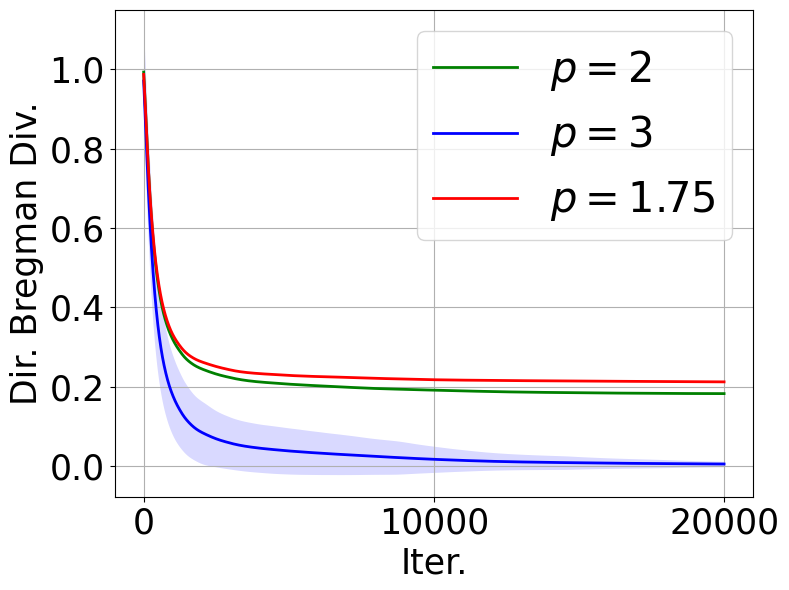

In [212]:
plt.figure(figsize=(8,6))
plt.locator_params(axis='x', nbins=4)

mean, std = all_corrs_2.mean(0)[:epochs], all_corrs_2.std(0)[:epochs]
plt.plot(mean[:epochs], color='g', linewidth=2, label=r'$p=2$')
# Uncomment to see standard div
# plt.fill_between(range(epochs), mean[:epochs]-std[:epochs], mean[:epochs]+std[:epochs], color='g', alpha=0.15, linewidth=0)

mean, std = all_corrs_3.mean(0)[:epochs], all_corrs_3.std(0)[:epochs]
plt.plot(mean[:epochs], color='b', linewidth=2, label=r'$p=3$')
# Uncomment to see standard div
plt.fill_between(range(epochs), mean[:epochs]-std[:epochs], mean[:epochs]+std[:epochs], color='b', alpha=0.15, linewidth=0)

mean, std = all_corrs_1_75.mean(0)[:epochs], all_corrs_1_75.std(0)[:epochs]
plt.plot(mean, color='r', linewidth=2, label=r'$p=1.75$')
# Uncomment to see standard div
# plt.fill_between(range(epochs), mean[:epochs]-std[:epochs], mean[:epochs]+std[:epochs], color='r', alpha=0.15, linewidth=0)

plt.legend(fontsize=30)
plt.xlabel('Iter.', fontsize=25)
plt.ylabel('Dir. Bregman Div.', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid()
plt.tight_layout()
plt.savefig(f"images/p{p}.jpg")
plt.show()

# Single Experiment

In [236]:
def plot_directions(Ws, W_att, i, j, p, arrow_idx=[], head_width=1.5, head_length=1.5, filename='result.jpg'):
    """
    Given the evolution of the parameter as it is being trained along
    with the Attention-SVM solution, plot the parameter's directions during
    training and the Attention-SVM direction

    Input:
    - Ws        : the evolution of the parameters as it is being trained
    - W_att     : the Attention-SVM solution
    - i, j      : the entries indices to compare
    - arrow_idx : the indices where we want to add arrows

    Display:
    One graph with one curved line with arrows on it and one straight
    line. Add grids and legends for clarity
    """
    # Rescale Attention-SVM
    factor = ((Ws[-1, i[0], i[1]] ** 2 + Ws[-1, j[0], j[1]] ** 2) ** .5
        / (W_att[i[0], i[1]] ** 2 + W_att[j[0], j[1]] ** 2) ** .5)
    
    # Actual Plots
    plt.plot(Ws[:, i[0], i[1]], Ws[:, j[0], j[1]], label=fr'$\ell_{{{p}}}$-AttGD')
    plt.plot([0, W_att[i[0], i[1]] * factor], [0, W_att[j[0], j[1]] * factor], label=fr'$\ell_{{{p}}}$-AttSVM')

    # Arrows
    for idx in arrow_idx:
        plt.arrow(
            Ws[idx, i[0], i[1]], Ws[idx, j[0], j[1]],
            Ws[idx+1, i[0], i[1]] - Ws[idx, i[0], i[1]],
            Ws[idx+1, j[0], j[1]] - Ws[idx, j[0], j[1]],
            length_includes_head=False, head_width=head_width, head_length=head_length,
            zorder=-1
        )

    # Display
    plt.grid()
    plt.legend(fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.savefig(filename)
    plt.show()

In [227]:
# Extract results
result1_75 = torch.load('result/convergence/p1_75/SingleW.pt')
result2 = torch.load('result/convergence/p2/SingleW.pt')
result3 = torch.load('result/convergence/p3/SingleW.pt')

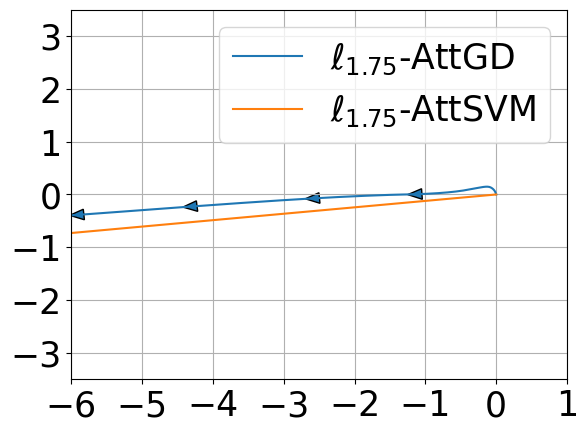

In [237]:
plt.xlim([-6, 1])
plt.ylim([-3.5, 3.5])
plot_directions(result1_75['Ws'], result1_75['att-svm'], (1, 2), (3, 4), 1.75, [140, 225, 310, 425], 0.2, 0.2, 'images/p1_75_instance.jpg')

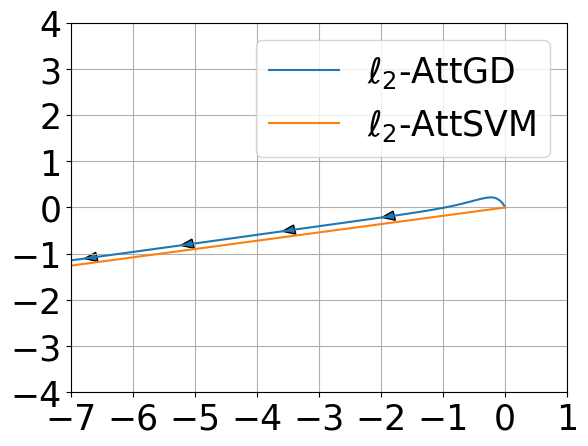

In [238]:
plt.xlim([-7, 1])
plt.ylim([-4, 4])
plot_directions(result2['Ws'], result2['att-svm'], (1, 2), (3, 4), 2, [300, 500, 700, 900], 0.2, 0.2, 'images/p2_instance.jpg')

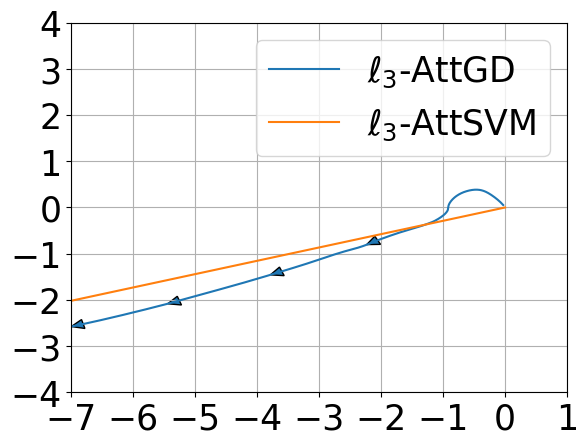

In [239]:
plt.xlim([-7, 1])
plt.ylim([-4, 4])
plot_directions(result3['Ws'], result3['att-svm'], (1, 2), (3, 4), 3, [1500, 4000, 8000, 13000], 0.2, 0.2, 'images/p3_instance.jpg')

# Joint Convergence

In [243]:
def plot_direction_joint(Ws, W_svm, vs, v_svm, Wij, vij, p, W_arrow_idx=[], v_arrow_idx=[], head_width=1.5, head_length=1.5, filename='result.jpg'):
    # Rescale Attention-SVM
    i, j = Wij[0], Wij[1]
    W_factor = ((Ws[-1, i[0], i[1]] ** 2 + Ws[-1, j[0], j[1]] ** 2) ** .5
    / (W_svm[i[0], i[1]] ** 2 + W_svm[j[0], j[1]] ** 2) ** .5)

    # Rescale v-SVM
    v_factor = ((vs[-1, vij[0]] ** 2 + vs[-1, vij[1]] ** 2) ** .5
        / (v_svm[vij[0]] ** 2 + v_svm[vij[1]] ** 2) ** .5)

    # Actual W Plots
    plt.plot(Ws[:, i[0], i[1]], Ws[:, j[0], j[1]], label=fr'$\ell_{{{p}}}$-JointGD-W')
    plt.plot([0, W_svm[i[0], i[1]] * W_factor], [0, W_svm[j[0], j[1]] * W_factor], label=fr'$\ell_{{{{p}}}}$-AttSVM')

    # Actual v Plots
    plt.plot(vs[:, vij[0]], vs[:, vij[1]], label=fr'$\ell_{{{p}}}$-JointGD-v')
    plt.plot([0, v_svm[vij[0]] * v_factor], [0, v_svm[vij[1]] * v_factor], label=fr'$\ell_{{{p}}}$-SVM')

    # W Arrows
    for idx in W_arrow_idx:
        plt.arrow(
            Ws[idx, i[0], i[1]], Ws[idx, j[0], j[1]],
            Ws[idx+1, i[0], i[1]] - Ws[idx, i[0], i[1]],
            Ws[idx+1, j[0], j[1]] - Ws[idx, j[0], j[1]],
            length_includes_head=False, head_width=head_width, head_length=head_length,
            zorder=-1
        )

    # v Arrows
    for idx in v_arrow_idx:
        plt.arrow(
            vs[idx, vij[0]], vs[idx, vij[1]],
            vs[idx+1, vij[0]] - vs[idx, vij[0]],
            vs[idx+1, vij[1]] - vs[idx, vij[1]],
            length_includes_head=False, head_width=head_width, head_length=head_length,
            zorder=-1
        )

    # Display
    plt.grid()
    plt.legend(fontsize=15)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig(filename)
    plt.show()

[[1]
 [0]]


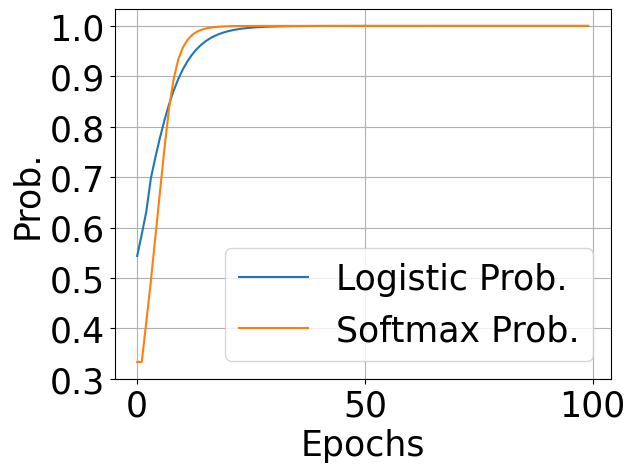

In [216]:
result = torch.load('result/joint_convergence/2.pt')
print(result['alpha'])
see_first = 100
plt.plot(result['log_prob'][:see_first], label='Logistic Prob.')
plt.plot(result['sfx_prob'][:see_first], label='Softmax Prob.')
plt.grid()
plt.locator_params(axis='x', nbins=4)
plt.legend(fontsize=25)
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Prob.', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig("images/p2-joint-prob.jpg")
plt.show()

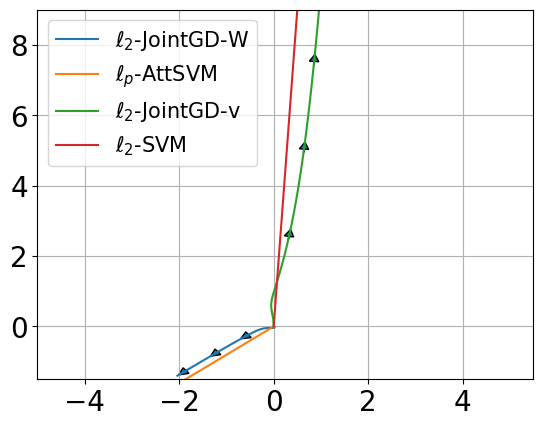

In [244]:
result = torch.load('result/joint_convergence/2.pt')
plt.xlim([-5, 5.5])
plt.ylim([-1.5, 9])
plot_direction_joint(
    result['Ws'],
    result['att-svm'][0],
    result['vs'],
    result['att-svm'][1],
    [(0, 0), (0, 1)],
    [0, 1],
    2,
    [20, 40, 60],
    [25, 50, 75],
    head_width=0.2, head_length=0.2,
    filename='images/p2-joint-iterates.jpg'
)

[[0]
 [0]]


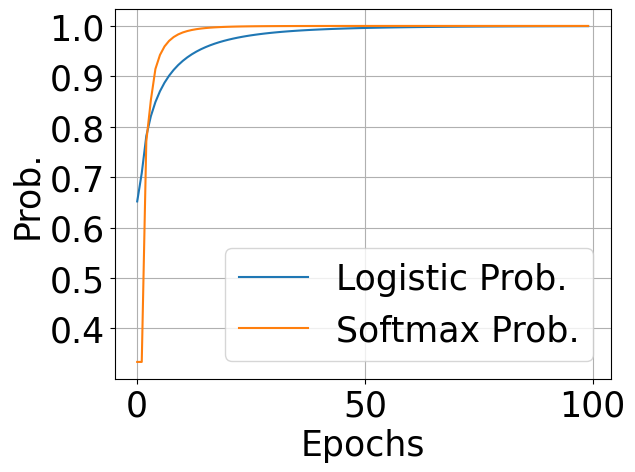

In [217]:
result = torch.load('result/joint_convergence/3.pt')
print(result['alpha'])
see_first = 100
plt.plot(result['log_prob'][:see_first], label='Logistic Prob.')
plt.plot(result['sfx_prob'][:see_first], label='Softmax Prob.')
plt.grid()
plt.locator_params(axis='x', nbins=4)
plt.legend(fontsize=25)
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Prob.', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig("images/p3-joint-prob.jpg")
plt.show()

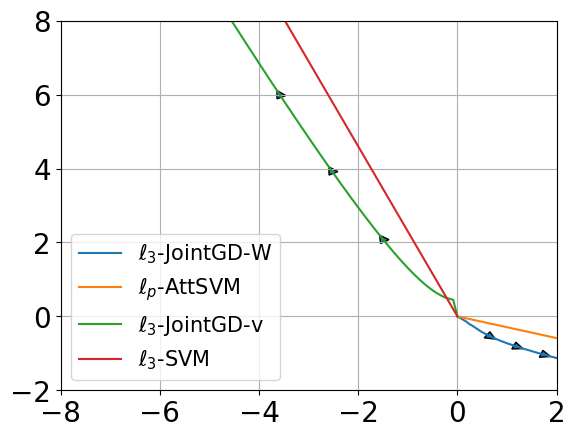

In [245]:
result = torch.load('result/joint_convergence/3.pt')
plt.xlim([-8, 2])
plt.ylim([-2, 8])
plot_direction_joint(
    result['Ws'],
    result['att-svm'][0],
    result['vs'],
    result['att-svm'][1],
    [(0, 0), (0, 1)],
    [0, 1],
    3,
    [15, 60, 130],
    [50, 175, 400],
    head_width=0.2, head_length=0.2,
    filename='images/p3-joint-iterates.jpg'
)

[[1]
 [0]]


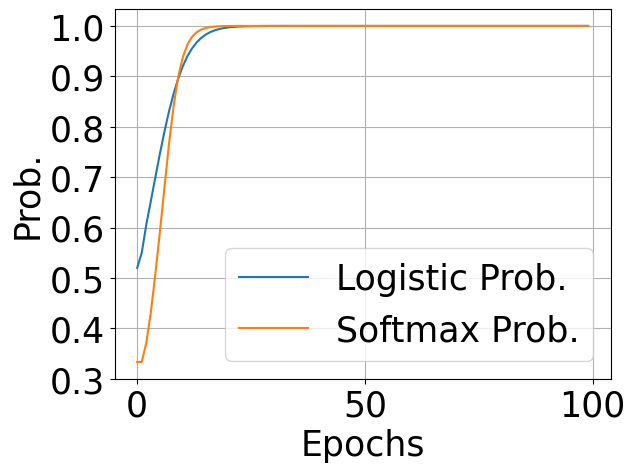

In [218]:
result = torch.load('result/joint_convergence/1_75.pt')
print(result['alpha'])
see_first = 100
plt.plot(result['log_prob'][:see_first], label='Logistic Prob.')
plt.plot(result['sfx_prob'][:see_first], label='Softmax Prob.')
plt.grid()
plt.locator_params(axis='x', nbins=4)
plt.legend(fontsize=25)
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Prob.', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig("images/p1_75-joint-prob.jpg")
plt.show()

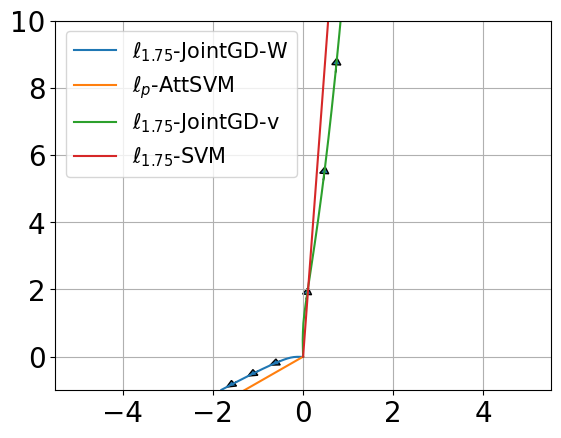

In [246]:
result = torch.load('result/joint_convergence/1_75.pt')
plt.xlim([-5.5, 5.5])
plt.ylim([-1, 10])
plot_direction_joint(
    result['Ws'],
    result['att-svm'][0],
    result['vs'],
    result['att-svm'][1],
    [(0, 0), (0, 1)],
    [0, 1],
    1.75,
    [20, 30, 38],
    [15, 35, 50],
    head_width=0.2, head_length=0.2,
    filename='images/p1_75-joint-iterates.jpg'
)